# How to easily deploy MACE training jobs with FORGE 

TODO:

1. The atoms don't seem to have their structure_id in the info dictionary for each structure. Right now it only goes into the structure_splits.json file? 
2. Need to more easily change parameters for the MACE training job. 

## Step 0 + 1: Initialize the libraries and the database connection

In [1]:
# Example Notebook: Using db_to_mace.py to Create MACE Training Jobs

import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

# Import the necessary modules
from forge.core.database import DatabaseManager
from forge.workflows.db_to_mace import prepare_mace_job, GPUConfig

# 1. Initialize the database connection
db_manager = DatabaseManager()  # This will use the default config path

## Step 2. Find the structures to use for training

Here we just select structures from generation 5 or later. You can sort structures based on their metadata. Or by their composition *WIP*

In [2]:
# 2. Query the database to find structures for training
# Let's find structures with completed VASP calculations
print("Finding structures from generation 5 or later")
vasp_structures = db_manager.find_structures_by_metadata({'generation' : 5}, operator='>=')
print(f"Found {len(vasp_structures)} structures with VASP calculations")

Finding structures from generation 5 or later
Found 3602 structures with VASP calculations


## Step 3: (Optional) Examine which types of configurations are in the training dataset

In [4]:
# 3. Let's examine the config_types in our dataset
atoms_list = db_manager.get_atoms_with_calculations(vasp_structures[:1000], calculator='vasp')
config_types = {}

for atoms in atoms_list:
    if 'config_type' in atoms.info:
        config_type = atoms.info['config_type']
        if config_type not in config_types:
            config_types[config_type] = []
        config_types[config_type].append(atoms)

print(f"Found {len(config_types)} different config_types in the first 1000 structures:")
for config_type, atoms_group in config_types.items():
    print(f"  - {config_type}: {len(atoms_group)} structures")

Found 17 different config_types in the first 1000 structures:
  - sia: 25 structures
  - comp-explore: 323 structures
  - liquid: 28 structures
  - short_range: 79 structures
  - vacancy-alloy: 136 structures
  - phonon: 20 structures
  - di-sia: 9 structures
  - surf_liquid: 16 structures
  - surface_100: 25 structures
  - dimer: 12 structures
  - dia: 88 structures
  - surface_110: 23 structures
  - surface_111: 21 structures
  - surface_112: 23 structures
  - hcp: 48 structures
  - C15: 66 structures
  - A15: 58 structures


## Step 4: (Optional) Visualize a few examples from each config_type

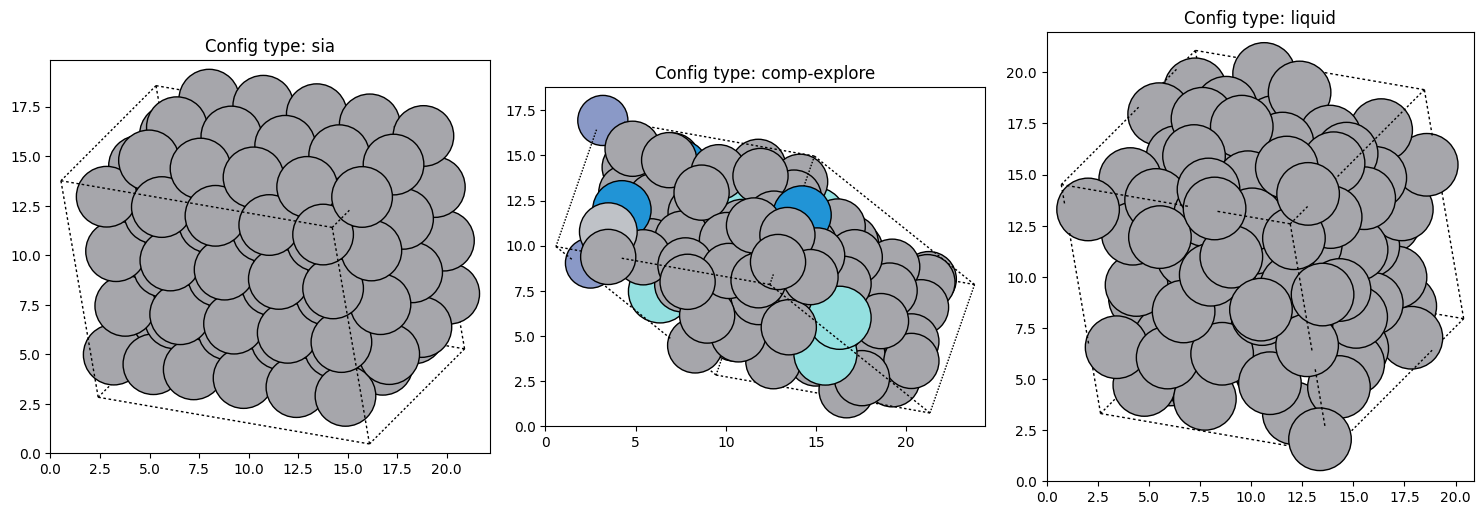

In [5]:
# 4. Let's select one example from each config_type for visualization
# Create a dictionary to store atoms by config_type
atoms_by_config_type = {}

# Group atoms by their config_type
for atoms in atoms_list:
    if 'config_type' in atoms.info:
        config_type = atoms.info['config_type']
        if config_type not in atoms_by_config_type:
            atoms_by_config_type[config_type] = []
        atoms_by_config_type[config_type].append(atoms)

# Randomly select one atoms object for each config_type
selected_atoms = {}
for config_type, atoms_group in atoms_by_config_type.items():
    selected_atoms[config_type] = random.choice(atoms_group)

# Visualize a few examples
fig, axes = plt.subplots(1, min(3, len(selected_atoms)), figsize=(15, 5))
if len(selected_atoms) <= 1:
    axes = [axes]  # Make axes iterable if there's only one subplot

for i, (config_type, atoms) in enumerate(list(selected_atoms.items())[:3]):
    plot_atoms(atoms, axes[i], rotation='45x,45y,45z')
    axes[i].set_title(f"Config type: {config_type}")

plt.tight_layout()
plt.show()

## Step 5: Here we define the parameters for the MACE training job

In the future need to show how to change other parameters like the max_epochs, learning rate, batch size, etc. 

In [3]:
# 5. Define parameters for the MACE training job
job_name = "mace_ensemble_example_new_database"
job_dir = Path("../data/mace_training_job_new_database")
gpu_config = {"count": 4, "type": "rtx6000"}  # Adjust based on your available hardware

## Step 6: Select the structures to use for training

Here we select a subset of structures to use for training. We can either select a specific number of random structures or select specific structure IDs based on the metadata search or composition search.

In [4]:
# 6. Select a subset of structures for training
# Option 1: Select a specific number of random structures
#num_structures = 500  # Adjust based on your dataset size

# Option 2: Or select specific structure IDs (uncomment if you want to use this)
structure_ids = vasp_structures[:1000]  # First 500 structures

## Step 7: Create the MACE training job with an ensemble of 3 models

Here we prepare the mace job and save the structure_splits.json file to the output path.

In [13]:
# 7. Create the MACE training job with an ensemble of 3 models
structure_splits = prepare_mace_job(
    db_manager=db_manager,
    job_name=job_name,
    job_dir=job_dir,
    gpu_config=gpu_config,
    structure_ids=structure_ids,  # Uncomment if using specific IDs
    #num_structures=num_structures,  # Comment out if using specific IDs
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    e0s="default",  # Use average for E0s
    seed=42,
    num_ensemble=3  # Create 3 ensemble models
)

Splitting 1000 structures into: 800 train, 100 val, 100 test

Processing train split with 800 structures
Attempting to save 800 structures to ../data/mace_training_job_new_database/data/mace_ensemble_example_new_database_train.xyz
Processing structure 0/800: ID=8525
Structure 8525 calculation info:
  calculator: vasp
  energy: -1042.0205
  forces shape: (124, 3)
  stress shape: (6,)
  atoms info: 124 atoms, cell=[[12.916574726, -0.023522817, -4.673697636], [-6.476478728, 11.341322303, -4.664862871], [-0.038053537, -0.055669889, 13.911869457]]
Processing structure 100/800: ID=8370
Structure 8370 calculation info:
  calculator: vasp
  energy: -52.022438
  forces shape: (6, 3)
  stress shape: (6,)
  atoms info: 6 atoms, cell=[[0.050280313, 4.0922182, 3.994313185], [3.28341042, 0.202710765, 3.587237468], [3.324998988, 3.415345537, 0.404481667]]
Processing structure 200/800: ID=8816
Structure 8816 calculation info:
  calculator: vasp
  energy: -1067.3708
  forces shape: (124, 3)
  stress sh

## Step 8: Output the job summary for the training. 

In [14]:
# 8. Print information about the created job
print("\nMANE Training Job Summary:")
print(f"Job name: {job_name}")
print(f"Job directory: {job_dir}")
print(f"Number of ensemble models: 3")
print(f"Data split:")
for split_name, struct_ids in structure_splits.items():
    print(f"  - {split_name}: {len(struct_ids)} structures")

# 9. List the created training scripts
print("\nCreated training scripts:")
for script_path in job_dir.glob("*_train.sh"):
    print(f"  - {script_path.name}")

# 10. Instructions for running the training job
print("\nTo run the training job, execute the following commands:")
print(f"cd {job_dir}")
for i in range(3):
    print(f"sbatch {job_name}_model_{i}_train.sh")


MANE Training Job Summary:
Job name: mace_ensemble_example_new_database
Job directory: ../data/mace_training_job_new_database
Number of ensemble models: 3
Data split:
  - train: 800 structures
  - val: 100 structures
  - test: 100 structures

Created training scripts:
  - mace_ensemble_example_new_database_model_0_train.sh
  - mace_ensemble_example_new_database_model_1_train.sh
  - mace_ensemble_example_new_database_model_2_train.sh

To run the training job, execute the following commands:
cd ../data/mace_training_job_new_database
sbatch mace_ensemble_example_new_database_model_0_train.sh
sbatch mace_ensemble_example_new_database_model_1_train.sh
sbatch mace_ensemble_example_new_database_model_2_train.sh


## Step 9: Ensure that the structure_splits.json file has the correct structure_id for each structure

In [16]:
from ase.io import read

test_data = read('../data/mace_training_job_new_database/data/mace_ensemble_example_new_database_test.xyz', index=':')
print(test_data[0].info['structure_index'])
print(test_data[0])

print(db_manager.get_structure(8618))

4
Atoms(symbols='Cr2Ti4V108W5Zr5', pbc=True, cell=[[12.916574726, -0.023522817, -4.673697636], [-6.476478728, 11.341322303, -4.664862871], [-0.038053537, -0.055669889, 13.911869457]], REF_force=...)
Atoms(symbols='Cr2Ti4V108W5Zr5', pbc=True, cell=[[12.916574726, -0.023522817, -4.673697636], [-6.476478728, 11.341322303, -4.664862871], [-0.038053537, -0.055669889, 13.911869457]])
